In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
from types import SimpleNamespace

from model import LinearModel
from loss import L2Loss
from optimizer import BFGS, InverseBFGS, DescentMethod, BarzilaiBorwein, IBFGSBBv2
from exceptions import IterationCompleteException
from utils import plot_results

args = SimpleNamespace(
    optimizer = 'backprop',
#     optimizer = 'bbv1',
#     optimizer = 'bbv2',
#     optimizer = 'bbv3',
#     optimizer = 'armijo',
#     optimizer = 'bfgs',
#     optimizer = 'ibfgs',
#     optimizer = 'ibfgsbbv2',
    maxsteps = 10000,
    target_loss = 1e-3,
    
    seed = 10,
    nsamples = 10,
    category_split = .5,
    visualize = False,
    plots_every = 4400,
    batchsize = 10,
    layerSizes = [2, 6, 10, 6, 2],
    loss = L2Loss()
)

In [2]:
np.random.seed(args.seed)
train_src = np.random.random((2,args.nsamples))

# train_src = np.array([
#     [0.1, 0.8, 0.6, 0.2, 0.4, 0.2, 0.4, 0.6, 0.7, 0.8],
#     [0.3, 0.2, 0.5, 0.6, 0.8, 0.8, 0.4, 0.4, 0.8, 0.4]
# ])
ndots = int(args.nsamples * args.category_split)

train_dst = np.array([
    [1]*ndots + [0]*(args.nsamples-ndots),
    [0]*ndots + [1]*(args.nsamples-ndots),
])

In [3]:
np.random.seed(args.seed)
model = LinearModel(widths=args.layerSizes, lr=0.5, loss=args.loss)
loss = args.loss

batch_size = args.batchsize

optimizer = None
if args.optimizer == 'ibfgs':
    optimizer = InverseBFGS(nparams=model.nparams, gamma=0.0001, eta=0.9)
elif args.optimizer == 'bfgs':
    optimizer = BFGS(nparams=model.nparams, gamma=0.0001, eta=0.9)
elif args.optimizer == 'armijo':
    optimizer = DescentMethod(nparams=model.nparams, beta=1/2, gamma=0.0001)
elif args.optimizer == 'bbv1' or args.optimizer == 'barzilaiborweinv1':
    optimizer = BarzilaiBorwein(nparams=model.nparams, beta=1/2, gamma=0.0001, strategy='v1')
elif args.optimizer == 'bbv2' or args.optimizer == 'barzilaiborweinv2':
    optimizer = BarzilaiBorwein(nparams=model.nparams, beta=1/2, gamma=0.0001, strategy='v2')
elif args.optimizer == 'bbv3' or args.optimizer == 'barzilaiborweinv3':
    optimizer = BarzilaiBorwein(nparams=model.nparams, beta=1/2, gamma=0.0001, strategy='alt')
elif args.optimizer == 'ibfgsbbv2':
    optimizer = IBFGSBBv2(nparams=model.nparams, gamma=0.0001, eta=0.9)
else:
    optimizer = None

 44%|████████████████████████████████████████████████████████████████████████                                                                                             | 4367/10000 [00:01<00:01, 3062.42it/s]


Iterations taken: 4400


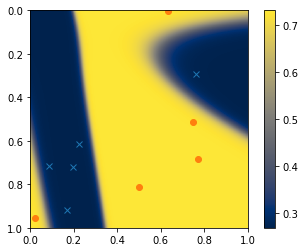

In [4]:
np.random.seed(args.seed)
losses = []
try:
    for i in tqdm(range(args.maxsteps)):
        batch = np.random.choice(range(train_src.shape[1]), batch_size, replace=False)
        x = train_src[:,batch]
        target = train_dst[:,batch]
        if not optimizer is None:
            res = model.train_step_optimizer(x, target, optimizer)
        else:
            res = model.train_step(x, target)
        total_loss = loss(res, target)
        losses.append(total_loss)
        if total_loss < args.target_loss:
            break
        if args.visualize and (i%args.plots_every==0):
            plot_results(model, train_src, train_dst, continuous=True,
                savename="results/main/" + args.optimizer + "_" + str(i) + "_" + str(args.maxsteps) + ".png"
            )
except (KeyboardInterrupt,IterationCompleteException):
    pass
print("Iterations taken:", i+1)
plot_results(model, train_src, train_dst, continuous=True,
    savename="results/main/" + args.optimizer + "_" + str(i+1) + "_" + str(args.maxsteps) + ".png"
)

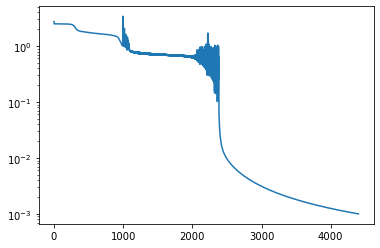

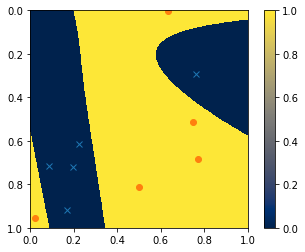

In [5]:
# plot training progress
plt.figure()
plt.semilogy(losses)
plt.savefig("results/main/" + args.optimizer + "_losses.png")
plt.show()

# plot training results
plot_results(model, train_src, train_dst,
    savename="results/main/" + args.optimizer + "_final" + ".png"
)